# Run each cell in the order

In [184]:
######################################################
#COMPLETE THE FOLLOWING ACCORDING TO YOUR MYSQL DATABASE
h=''
u=''
db=''
pswrd=''
######################################################

In [186]:
from IPython.core.display import display, HTML
display(HTML(r"""<style id=hide>div.input{display:none;}</style><button type="button"onclick="var myStyle =document.getElementById('hide').sheet;myStyle.insertRule('div.input{display:inherit !important;}', 0);">Show inputs</button>"""))


### See a list of company names in the database along with their symbols and available date range.

In [187]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from numpy import *
import mysql.connector
from mysql.connector import Error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

import decimal
import math
import datetime

# SQL and basic setup

# Allowing users to find out the name of the symbol by choosing the name of the company
try:
    # connecting to SQL database
    mySQLconnection = mysql.connector.connect(host=h,
                             database=db,
                             user=u,
                             password=pswrd)
    
    # Actual Query here
    
    # First, I get the range of dates for each stock and their corresponding names 
    sql_select_Query = "Select name,T.symbol,S_date,E_date From Symbols,\
                        (select MIN(date) as S_date, MAX(date) as E_date,symbol\
                        from daily_stock group by symbol) as T\
                        where T.symbol = symbols.symbol Order by name;"
    cursor = mySQLconnection.cursor()
    cursor.execute(sql_select_Query)
    records = cursor.fetchall()
    
    # grabbing all information 
    N = [x[0] for x in records]
    S = [x[1] for x in records]
    s_date = [x[2] for x in records]
    e_date = [x[3] for x in records]
    cursor.close()
   
except Error as e :
    print ("Error", e)
    
finally:
    #closing database connection.
    if(mySQLconnection.is_connected()):
        mySQLconnection.close()
        
        
# Interactive widget to take user input
s = widgets.Select(
    options=N,
    value="3M Company",
    description='Symbol:',
    disabled=False)

def f(s):
    count=0
    for x in N:
        if (x==s):
            break
        count+=1
    print (S[count])
    print ("Start Date: "+str(s_date[count]))
    print ("End Date: "+str(e_date[count]))

out = widgets.interactive_output(f, {'s': s})
widgets.HBox([widgets.VBox([s]), out]) 


### Pick a symbol, start date, and end date

In [188]:
# Now that the user knows the name of the symbol, make them type in the name of the symbol

# get user input
inputS = input("Enter symbol to see the historical stock prices: ").upper()

count=0
for x in S:
    if (x==inputS):
        s_name=N[count]
        print ("You have chosen "+s_name+" as your stock")
        break
    count+=1
if count == len(S) :
    print("ERROR: "+inputS+" is not a symbol in dataset. Check and re-enter the symbol.")

Enter symbol to see the historical stock prices: GS
You have chosen Goldman Sachs as your stock


In [189]:
inputS_date = input("Enter the Start date (yyyy-mm-dd): ")
try:
    sd = datetime.datetime.strptime(inputS_date, '%Y-%m-%d').date()
except ValueError:
    print("ERROR: "+"Start date was not in the correct format. Please re-enter")

Enter the Start date (yyyy-mm-dd): 2007-1-1


In [190]:
inputE_date = input("Enter the End date (yyyy-mm-dd): ")
try:
    ed = datetime.datetime.strptime(inputE_date, '%Y-%m-%d').date()
    if ed<sd:
        print("Error: Your End date is before Start date. Please re-enter")
except ValueError:
    print("ERROR: "+"End date was not in the correct format. Please re-enter")

Enter the End date (yyyy-mm-dd): 2010-1-1


### Check and change dates to the closest available

In [191]:
## INPUT CHECKING

try:
        # connecting to SQL database
        mySQLconnection = mysql.connector.connect(host=h,
                             database=db,
                             user=u,
                             password=pswrd)
    
        # Checking the dates
        sql_select_Query = "Select MIN(date), MAX(date) \
                        from daily_stock \
                        where symbol='"+ inputS+ "' AND date between '"+inputS_date+"' and '"+inputE_date+"'"
        
        cursor = mySQLconnection.cursor()
        cursor.execute(sql_select_Query)
        records = cursor.fetchall()
        

        if records is None:
            print("ERROR: "+inputS+" is in the dataset but there is no data between "+inputS_date+" and "+inputE_date)
            print("Please Re-enter the dates.")
        else:
            d_start=records[0][0]
            d_end = records[0][1]
            if sd!=records[0][0]:
                print("Your start date was not valid.")
                print("Changing "+inputS_date+" to the closest avaiable date: "+str(d_start))
                sd = d_start
                inputS_date = sd.strftime('%Y-%m-%d')
            if ed!=records[0][1]:
                print("Your end date was not valid.")
                print("Changing "+inputE_date+" to the closest avaiable date: "+str(d_end))
                ed = d_end
                inputE_date = ed.strftime('%Y-%m-%d')
            
            print ("You are good to move on. Chosen timeline is "+str(sd)+" to "+str(ed))
   
except Error as e :
        print ("Error", e)
    
finally:
        #closing database connection.
        if(mySQLconnection.is_connected()):
            mySQLconnection.close()

Your start date was not valid.
Changing 2007-1-1 to the closest avaiable date: 2007-01-03
Your end date was not valid.
Changing 2010-1-1 to the closest avaiable date: 2009-12-31
You are good to move on. Chosen timeline is 2007-01-03 to 2009-12-31


# Historical stock prices and trading strategies

### Stock return fluctuation

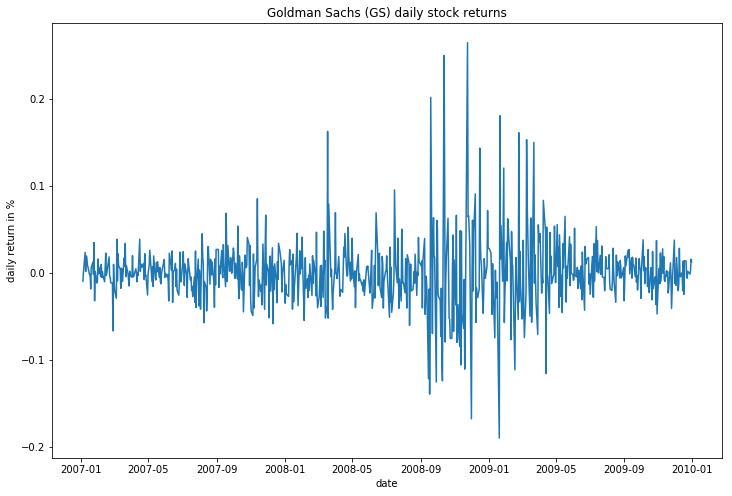

In [192]:


try:
    # connecting to SQL database
    mySQLconnection = mysql.connector.connect(host=h,
                             database=db,
                             user=u,
                             password=pswrd)
    
    # Actual Query here
    sql_select_Query = "select date,d_adjusted_close from daily_stock where symbol='"+inputS+"' AND date between \
    '"+inputS_date+"' and '"+inputE_date+"' ORDER BY date"
    cursor = mySQLconnection.cursor()
    cursor.execute(sql_select_Query)
    df = pd.DataFrame(cursor.fetchall())
    df[1]=df[1].astype(float)
    df['d_return']= df[1].pct_change(1)
    
    plt.plot(df[0],df['d_return'])
    plt.xlabel("date")
    plt.ylabel("daily return in %")
    plt.title(s_name+" ("+inputS+") daily stock returns")
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
        
    plt.show()
    
    cursor.close()
   
except Error as e :
    print ("Error", e)
    
finally:
    #closing database connection.
    if(mySQLconnection.is_connected()):
        mySQLconnection.close()

##### Buy and Hold

Buy and hold: GS
Dates: 2007-01-03 -> 2009-12-31
One share:  $172.80 -> $149.44
           ($100  -> $86.48)

Negative Return
Overall: -13.52% over 1093 days
Daily average: -0.01329%
Annually average: -4.736%

Total dividends = $4.3167



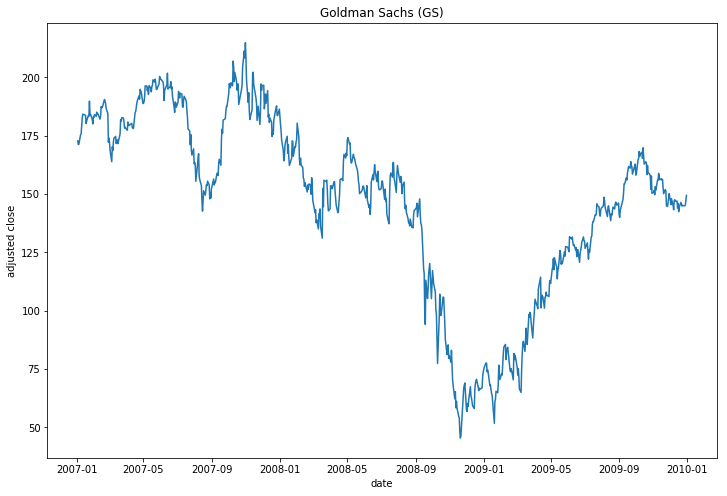

In [193]:
# This block returns the initial date and the most recent date along with its opening and closing prices
# This also returns the % return along with the number of days
# The graph is also presented


try:
    # connecting to SQL database
    mySQLconnection = mysql.connector.connect(host=h,
                             database=db,
                             user=u,
                             password=pswrd)
    
    # Actual Query here
    sql_select_Query = "select d_adjusted_close from daily_stock where symbol='"+inputS+"' AND date ='"+inputS_date+"'"
    cursor = mySQLconnection.cursor()
    cursor.execute(sql_select_Query)
    records = cursor.fetchall()
    initial_p = records[0][0]
    
    # grab end date and end price
    sql_select_Query = "select d_adjusted_close from daily_stock where symbol='"+inputS+"' AND date ='"+inputE_date+"'"
    cursor.execute(sql_select_Query)
    records = cursor.fetchall()
    last_p = records[0][0]
    
    # Basic information returned
    print ("Buy and hold: "+inputS)
    print ("Dates: "+ inputS_date +" -> "+ inputE_date)
    print ("One share:  $"+ ("%.2f"%initial_p)+" -> $"+("%.2f" % last_p))
    print ("           ($100  -> $"+str("%.2f"%(last_p*100/initial_p))+")")
    print()
    # Calculation for returns
    n = (ed-sd).days
    r = (last_p/initial_p)
    d_r = (math.pow((r),(1/n))-1)
    y_r = math.pow((1+d_r),365)-1
    
    # Information regarding the returns 
    if (r<=1):
        r=r-1
        print("Negative Return")
    else:
        r=r-1
        print("Positive Return")
    print("Overall: "+"%.2f" % (r*100) +"% over "+ str(n)+ " days")
    print("Daily average: "+  "%.5f" % (d_r*100) + "%")
    print ( "Annually average: "+ "%.3f" % (y_r*100) + "%")
    
    
    
    print()
    sql_select_Query = "select SUM(d_dividend) from daily_stock where symbol='"+inputS+"'\
        and date between '"+inputS_date+"' and '"+inputE_date+"' GROUP BY symbol;"
    cursor.execute(sql_select_Query)
    records = cursor.fetchall()
    
    print("Total dividends = $" + str(records[0][0]))
    print()
    
    
    sql_select_Query = "Select date, d_adjusted_close from daily_stock where symbol='"+inputS+"' and \
    date between '"+inputS_date+"' and '"+inputE_date+"'"
    cursor = mySQLconnection.cursor()
    cursor.execute(sql_select_Query)
    records = cursor.fetchall()
    date = [x[0] for x in records]
    ad_close = [x[1] for x in records]
    
    plt.plot(date,ad_close)
    
        
    plt.xlabel("date")
    plt.ylabel("adjusted close")
    plt.title(s_name+" ("+inputS+")")
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
        
    plt.show()
    cursor.close()
   
except Error as e :
    print ("Error", e)
    
finally:
    #closing database connection.
    if(mySQLconnection.is_connected()):
        mySQLconnection.close()
        

### Long-Short
##### * not adjusted for dividends and trading costs
##### Simple Moving Average  https://www.investopedia.com/terms/s/sma.asp

Simple Moving Averages: GS
Dates: 2007-01-03 -> 2009-12-31
One share:  $200.72 -> $168.84

Buy and Hold Return: $-31.88

10 day SMA crossing 30 day SMA: $188.11
30 day SMA crossing 50 day SMA: $206.05
10 day SMA crossing 50 day SMA: $161.94


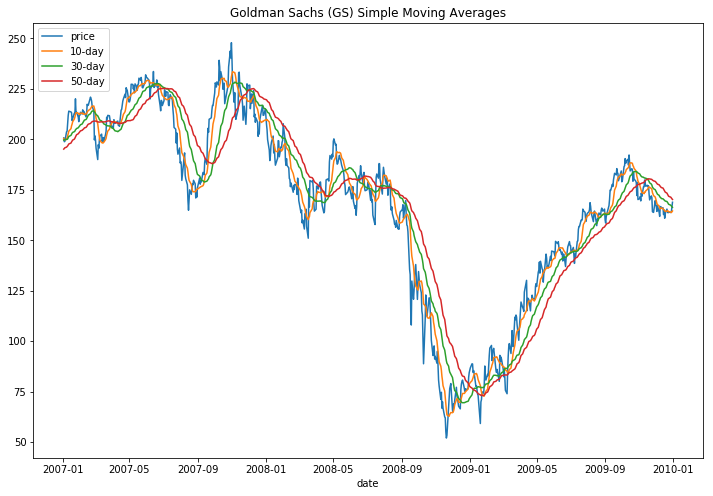

In [194]:
# Graphing Technical Indicators 

try:
        # connecting to SQL database
        mySQLconnection = mysql.connector.connect(host=h,
                             database=db,
                             user=u,
                             password=pswrd)
        # Checking the dates
        sql_select_Query = "Select daily_stock.date,d_close,sma10,sma30,sma50, \
        ema10,ema30,ema50,macd,macd_signal\
        From daily_stock, technical_analysis \
        Where daily_stock.symbol='"+inputS+"' AND daily_stock.date between '"+inputS_date+"' and '"+inputE_date+"'\
            and daily_stock.daily_id=technical_analysis.ta_id ORDER BY daily_stock.date"
        cursor = mySQLconnection.cursor()
        cursor.execute(sql_select_Query)
        records = cursor.fetchall()
    
        # setting up and plotting graph
        date = [x[0] for x in records]
        close = [x[1] for x in records]
        s10 = [x[2] for x in records]
        s30 = [x[3] for x in records]
        s50= [x[4] for x in records]
        e10= [x[5] for x in records]
        e30= [x[6] for x in records]
        e50= [x[7] for x in records]
        macd= [x[8] for x in records]
        macd_s= [x[9] for x in records]
except Error as e :
        print ("Error", e)
    
finally:
        #closing database connection.
        if(mySQLconnection.is_connected()):
            mySQLconnection.close()


# Basic information returned
print ("Simple Moving Averages: "+inputS)
print ("Dates: "+ str(date[0]) +" -> "+ str(date[len(date)-1]))
print ("One share:  $"+ ("%.2f"%close[0])+" -> $"+("%.2f" % close[len(close)-1]))
print()
print("Buy and Hold Return: $"+ "%.2f"%(close[len(close)-1]-close[0]))
print()

# Calculation for returns

count=1
investment=float(close[0])
position=0
for x in date:
    if count==(len(date)-1):
        break
    if (s10[count]>s30[count] and s10[count-1]<s30[count-1]):
        if(position==-1):
            investment = investment-float(close[count])
        position=1
        investment=investment-float(close[count])
    if (s10[count]<s30[count] and s10[count-1]>s30[count-1]):
        if (position==1):
            investment=investment+float(close[count])
        investment=investment+float(close[count])
        position=-1
    count=count+1
if (position==1):
    investment+=float(close[count])
if (position==-1):
    investment = investment - float(close[count])
investment=investment-float(close[0])

print("10 day SMA crossing 30 day SMA: $"+"%.2f" %(investment))

count=1
investment=float(close[0])
position=0
for x in date:
    if count==(len(date)-1):
        break
    if (s30[count]>s50[count] and s30[count-1]<s50[count-1]):
        if(position==-1):
            investment = investment-float(close[count])
        position=1
        investment=investment-float(close[count])
    if (s30[count]<s50[count] and s30[count-1]>s50[count-1]):
        if (position==1):
            investment=investment+float(close[count])
        investment=investment+float(close[count])
        position=-1
    count=count+1
if (position==1):
    investment+=float(close[count])
if (position==-1):
    investment = investment - float(close[count])
investment=investment-float(close[0])
print("30 day SMA crossing 50 day SMA: $"+"%.2f" %(investment))


count=1
investment=float(close[0])
position=0
for x in date:
    if count==(len(date)-1):
        break
    if (s10[count]>s50[count] and s10[count-1]<s50[count-1]):
        if(position==-1):
            investment = investment-float(close[count])
        position=1
        investment=investment-float(close[count])
    if (s10[count]<s50[count] and s10[count-1]>s50[count-1]):
        if (position==1):
            investment=investment+float(close[count])
        investment=investment+float(close[count])
        position=-1
    count=count+1
if (position==1):
    investment+=float(close[count])
if (position==-1):
    investment = investment - float(close[count])
investment=investment-float(close[0])
print("10 day SMA crossing 50 day SMA: $"+"%.2f" %(investment))

plt.plot(date,close)
plt.plot(date,s10)
plt.plot(date,s30)
plt.plot(date,s50)
plt.legend(['price', '10-day', '30-day','50-day'], loc='upper left')

plt.xlabel("date")
plt.title(s_name+" ("+inputS+")"+" Simple Moving Averages")
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.show()
    

##### Exponential Moving Average https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp

Exponential Moving Averages: GS
Dates: 2007-01-03 -> 2009-12-31
One share:  $200.72 -> $168.84

Buy and Hold Return: $-31.88

10 day EMA crossing 30 day EMA: $16.71
30 day EMA crossing 50 day EMA: $32.23
10 day EMA crossing 50 day EMA: $29.93


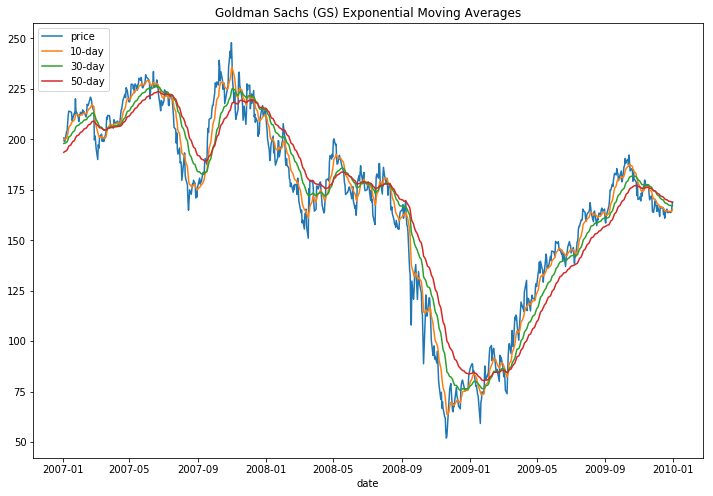

In [195]:
# Basic information returned
print ("Exponential Moving Averages: "+inputS)
print ("Dates: "+ str(date[0]) +" -> "+ str(date[len(date)-1]))
print ("One share:  $"+ ("%.2f"%close[0])+" -> $"+("%.2f" % close[len(close)-1]))
print()
print("Buy and Hold Return: $"+ "%.2f"%(close[len(close)-1]-close[0]))
print()

# Calculation for returns


count=1
investment=float(close[0])
position=0
for x in date:
    if count==(len(date)-1):
        break
    if (e10[count]>e30[count] and e10[count-1]<e30[count-1]):
        if(position==-1):
            investment = investment-float(close[count])
        position=1
        investment=investment-float(close[count])
    if (e10[count]<e30[count] and e10[count-1]>e30[count-1]):
        if (position==1):
            investment=investment+float(close[count])
        investment=investment+float(close[count])
        position=-1
    count=count+1
if (position==1):
    investment+=float(close[count])
if (position==-1):
    investment = investment - float(close[count])
investment=investment-float(close[0])

print("10 day EMA crossing 30 day EMA: $"+"%.2f" %(investment))

count=1
investment=float(close[0])
position=0
for x in date:
    if count==(len(date)-1):
        break
    if (e30[count]>e50[count] and e30[count-1]<e50[count-1]):
        if(position==-1):
            investment = investment-float(close[count])
        position=1
        investment=investment-float(close[count])
    if (e30[count]<e50[count] and e30[count-1]>e50[count-1]):
        if (position==1):
            investment=investment+float(close[count])
        investment=investment+float(close[count])
        position=-1
    count=count+1
if (position==1):
    investment+=float(close[count])
if (position==-1):
    investment = investment - float(close[count])
investment=investment-float(close[0])
print("30 day EMA crossing 50 day EMA: $"+"%.2f" %(investment))


count=1
investment=float(close[0])
position=0
for x in date:
    if count==(len(date)-1):
        break
    if (e10[count]>e50[count] and e10[count-1]<e50[count-1]):
        if(position==-1):
            investment = investment-float(close[count])
        position=1
        investment=investment-float(close[count])
    if (e10[count]<e50[count] and e10[count-1]>e50[count-1]):
        if (position==1):
            investment=investment+float(close[count])
        investment=investment+float(close[count])
        position=-1
    count=count+1
if (position==1):
    investment+=float(close[count])
if (position==-1):
    investment = investment - float(close[count])
investment=investment-float(close[0])
print("10 day EMA crossing 50 day EMA: $"+"%.2f" %(investment))

plt.plot(date,close)
plt.plot(date,e10)
plt.plot(date,e30)
plt.plot(date,e50)
plt.legend(['price', '10-day', '30-day','50-day'], loc='upper left')

plt.xlabel("date")
plt.title(s_name+" ("+inputS+")"+" Exponential Moving Averages")
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.show()

#### Moving Average Convergence Divergence https://www.investopedia.com/terms/m/macd.asp

Long-Short Trading Strategy Based on MACD: GS
Dates: 2007-01-03 -> 2009-12-31
One share:  $200.72 -> $168.84

Buy and Hold Return: $-31.88

MACD return: $-5.35


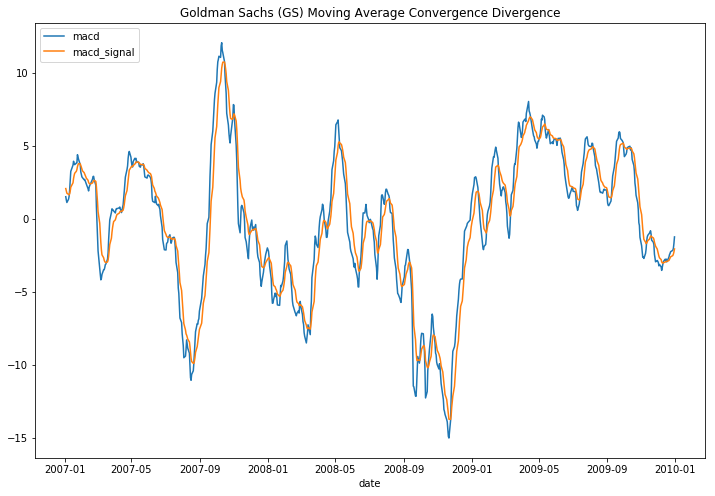

In [196]:
count=1
investment=float(close[0])
position=0
for x in date:
    if count==(len(date)-1):
        break
    if (macd[count]>macd_s[count] and macd[count-1]<macd_s[count-1]):
        if(position==-1):
            investment = investment-float(close[count])
        position=1
        investment=investment-float(close[count])
    if (macd[count]<macd_s[count] and macd[count-1]>macd_s[count-1]):
        if (position==1):
            investment=investment+float(close[count])
        investment=investment+float(close[count])
        position=-1
    count=count+1
if (position==1):
    investment+=float(close[count])
if (position==-1):
    investment = investment - float(close[count])

print ("Long-Short Trading Strategy Based on MACD: "+inputS)
print ("Dates: "+ str(date[0]) +" -> "+ str(date[len(date)-1]))
print ("One share:  $"+ ("%.2f"%close[0])+" -> $"+("%.2f" % close[len(close)-1]))
print()
print("Buy and Hold Return: $"+ "%.2f"%(close[len(close)-1]-close[0]))
print()
print("MACD return: $"+"%.2f" %(investment))

plt.plot(date,macd)
plt.plot(date,macd_s)
plt.legend(['macd','macd_signal'], loc='upper left')

plt.xlabel("date")
plt.title(s_name+" ("+inputS+")"+" Moving Average Convergence Divergence")
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.show()


# Stock price fluctuations with respect to monthly macroeconomic indicators

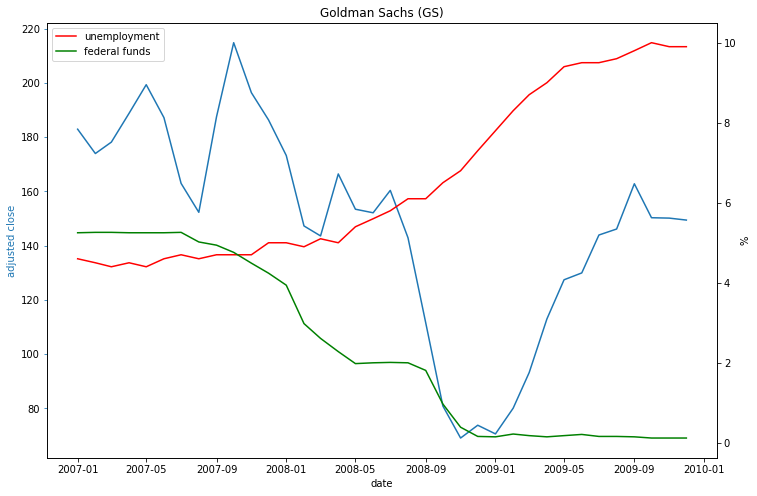

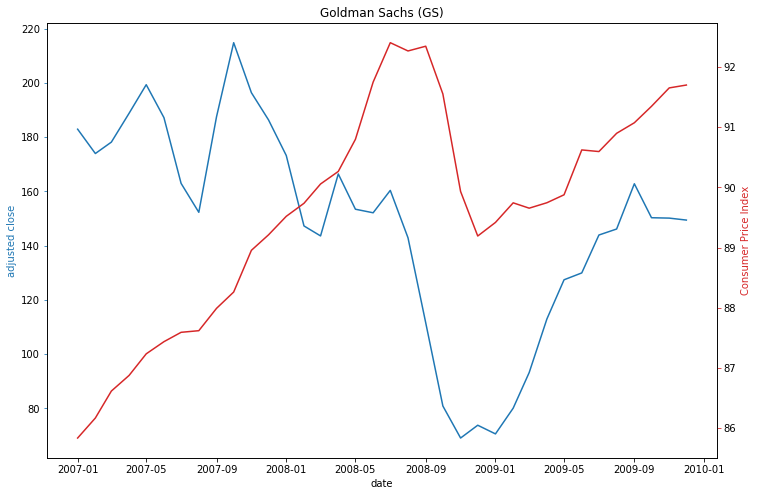

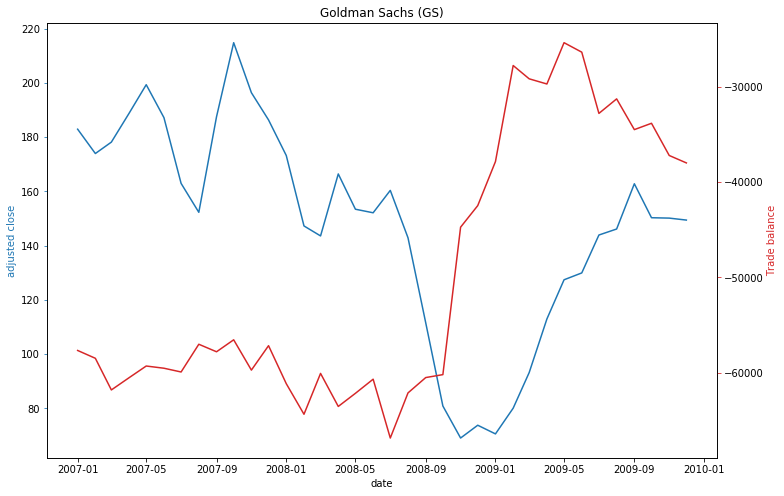

In [197]:
try:
    # connecting to SQL database
    mySQLconnection = mysql.connector.connect(host=h,
                             database=db,
                             user=u,
                             password=pswrd)
    
    # Actual Query here
    sql_select_Query = "Select monthly_macro.date, d_adjusted_close, unemployment,fed_funds, cpi, trade_balance \
from m_adj, monthly_macro \
where m_adj.symbol = '"+inputS+"' and m_adj.date between '"+inputS_date+"' and '"+inputE_date+"' and \
year=extract(year from m_adj.date) and \
month=extract(month from m_adj.date)"

    cursor = mySQLconnection.cursor()
    cursor.execute(sql_select_Query)
    records = cursor.fetchall()
    
    date = [x[0] for x in records]
    close = [x[1] for x in records]
    unemployment = [x[2] for x in records]
    fed_funds = [x[3] for x in records]
    cpi = [x[4] for x in records]
    trade_balance = [x[5] for x in records]
    
 
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('date')
    ax1.set_ylabel('adjusted close',color=color)
    ax1.plot(date,close,color=color)
    ax1.tick_params(axis='y',color=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color='tab:red'
    ax2.set_ylabel('%')  # we already handled the x-label with ax1
    ax2.plot(date,unemployment, color='red')
    ax2.plot(date,fed_funds,color='green')
    ax2.tick_params(axis='y')
    
    plt.legend(['unemployment','federal funds'], loc='upper left')
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    plt.title(s_name+" ("+inputS+")")
    plt.show()
    ######
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('date')
    ax1.set_ylabel('adjusted close',color=color)
    ax1.plot(date,close,color=color)
    ax1.tick_params(axis='y',color=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color='tab:red'
    ax2.set_ylabel('Consumer Price Index',color=color)  # we already handled the x-label with ax1
    ax2.plot(date,cpi,color=color)
    ax2.tick_params(axis='y',color=color)
    
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    plt.title(s_name+" ("+inputS+")")
    plt.show()
    ######
    
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('date')
    ax1.set_ylabel('adjusted close',color=color)
    ax1.plot(date,close,color=color)
    ax1.tick_params(axis='y',color=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color='tab:red'
    ax2.set_ylabel('Trade balance',color=color)  # we already handled the x-label with ax1
    ax2.plot(date,trade_balance,color=color)
    ax2.tick_params(axis='y',color=color)
    
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    plt.title(s_name+" ("+inputS+")")
    plt.show()
    

    cursor.close()
   
except Error as e :
    print ("Error", e)
    
finally:
    #closing database connection.
    if(mySQLconnection.is_connected()):
        mySQLconnection.close()